In [2]:
import pandas as pd
# get the csv file
# /media/Volume/data/MIT-BHI/data/

# read the csv file
df = pd.read_csv('/media/Volume/data/MIT-BHI/data/t_wave_split/labels_train.csv')
# get the first index where is_oversampled is True

idx = df[df['is_oversampled'] == True].index[8]
print(idx)

# get the dataframe from the idx to next 10 rows
df['len'] = df['hb_end'] - df['hb_start']
df['win_size'] = df['win_end'] - df['win_start']

# subtract the win_start from the previous win_start
df['win_start_diff'] = df['win_start'].diff()
df['hb_len'] = df['hb_end'] - df['hb_start']

df.head(n = 10)
# get hte maximum win size
max_win_size = df['win_size'].max()
print(max_win_size)

# get the row where the win_size is maximum
max_win_size_row = df[df['win_size'] == max_win_size]

print(max_win_size_row)

369
3724
       patient  sample_id orig_label label  hb_start  hb_end  r_peak  \
47754      208       2104          Q     Q    458221  458655  458621   

       is_oversampled  win_start  win_end  len  win_size  win_start_diff  \
47754            True     458221   461945  434      3724          1400.0   

       hb_len  
47754     434  


In [3]:
from dataset.helper_code_code15 import load_label
import numpy as np
import pandas as pd

# load the label
from dataset.helper_code_code15 import find_records, load_label, load_signals, load_header, get_age, get_sex

folder = '/media/Volume/data/CODE15/unlabeled_records_360_nkclean/'
csv_file = '/media/Volume/data/CODE15/exams.csv'
exams = pd.read_csv(csv_file)
records = find_records(folder)

# make exam_id the index
exams.set_index('exam_id', inplace = True)
exams.head(n = 100)


,age,is_male,nn_predicted_age,1dAVb,RBBB,LBBB,SB,ST,AF,patient_id,death,timey,normal_ecg,trace_file
exam_id,,,,,,,,,,,,,,
1169160,38,True,40.160484,False,False,False,False,False,False,523632,False,2.098628,True,exams_part13.hdf5
2873686,73,True,67.059440,False,False,False,False,False,False,1724173,False,6.657529,False,exams_part13.hdf5
168405,67,True,79.621740,False,False,False,False,False,True,51421,False,4.282188,False,exams_part13.hdf5
271011,41,True,69.750260,False,False,False,False,False,False,1737282,False,4.038353,True,exams_part13.hdf5
384368,73,True,78.873460,False,False,False,False,False,False,331652,False,3.786298,False,exams_part13.hdf5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908765,66,False,58.220650,False,False,False,False,False,False,972046,False,2.630135,False,exams_part14.hdf5
3409819,48,True,52.687810,False,False,False,False,False,False,856657,False,5.473968,False,exams_part13.hdf5
903967,52,False,32.229412,False,False,False,False,False,False,686518,False,2.638354,True,exams_part13.hdf5


In [4]:
from dataset.helper_code_code15 import load_text
sample1 = records[0]
sample2 = records[1]
print(sample1)
signals = load_signals(folder + sample1)

# get the row in the exams dataframe
exam_row = exams.loc[int(sample1)]
exam_row2 = exams.loc[int(sample2)]

cat = pd.concat([exam_row, exam_row2], axis = 1)
cat.head(n=30)

100


,100,1000001
age,72,22
is_male,True,False
nn_predicted_age,70.60231,26.017557
1dAVb,False,False
RBBB,True,False
LBBB,False,False
SB,True,False
ST,False,False
AF,False,False
patient_id,24004,415631


In [5]:
import os
import wfdb

mit_lbl = pd.read_csv(os.path.join('/media/Volume/data/MIT-BHI/data/', 't_wave_split', f'labels_train.csv'))

annotation = wfdb.rdann(os.path.join('/media/Volume/data/MIT-BHI/data/' + 'raw', f'{201}'), 'atr')
header = wfdb.rdheader(os.path.join('/media/Volume/data/MIT-BHI/data/' + 'raw', f'{111}'))
print(header.__dict__['comments'])

['47 F 937 167 x1', 'Digoxin, Lasix', 'There is first degree AV block.  There are short bursts of both baseline', 'shifts and muscle noise, but in general, the quality is excellent.']


In [6]:
# load the model from checkpoint
from models.xLSTM import myxLSTM
import torch

#without gradient loss
# path = 'lightning_logs/version_107/checkpoints/epoch=5-step=16176.ckpt'

#with gradient loss
# path = 'lightning_logs/version_108/checkpoints/epoch=3-step=10784.ckpt'
# path = 'lightning_logs/version_111/checkpoints/epoch=5-step=16176.ckpt'
# path = 'pretrain-xLSTM/xyq7f8n9/checkpoints/epoch=3-step=10784.ckpt'


# grad loss ps 128
path = 'pretrain-xLSTM/0fejj0dx/checkpoints/epoch=7-step=21568.ckpt'

patch_size=128
xlstm = myxLSTM(patch_size=patch_size, dropout=0.1, embedding_size=1024, activation_fn='relu', xlstm_depth=8, multi_token_prediction=True)
checkpoint = torch.load(path)
print(checkpoint.keys())
print(checkpoint['hyper_parameters'])
state_dict = checkpoint['state_dict']
# Remove 'model.' prefix from keys
new_state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}
print(new_state_dict.keys())
xlstm.load_state_dict(new_state_dict, strict=True)
xlstm.eval()


{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda-12.6/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=1024', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-D

Using /home/luna97/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/luna97/.cache/torch_extensions/py311_cu124/slstm_HS1024BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/home/luna97/Research/MIT-BIH_ecg_arrhytmia/mit_bih_env/lib/python3.11/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS1024BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slstm_HS1024BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/home/luna97/Research/MIT-BIH_ecg_arrhytmia/mit_bih_env/lib/python3.11/site-packages/xlstm/blocks/slstm/c

ninja: no work to do.
{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda-12.6/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=1024', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-devi

Using /home/luna97/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS1024BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS1024BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/tmp/ipykernel_190968/64914230.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seri

FileNotFoundError: [Errno 2] No such file or directory: 'pretrain-xLSTM/0fejj0dx/checkpoints/epoch=7-step=21568.ckpt'

1
sample shape torch.Size([1, 3600, 1])
rec shape torch.Size([1, 3712])
shift_x shape torch.Size([1, 3584])


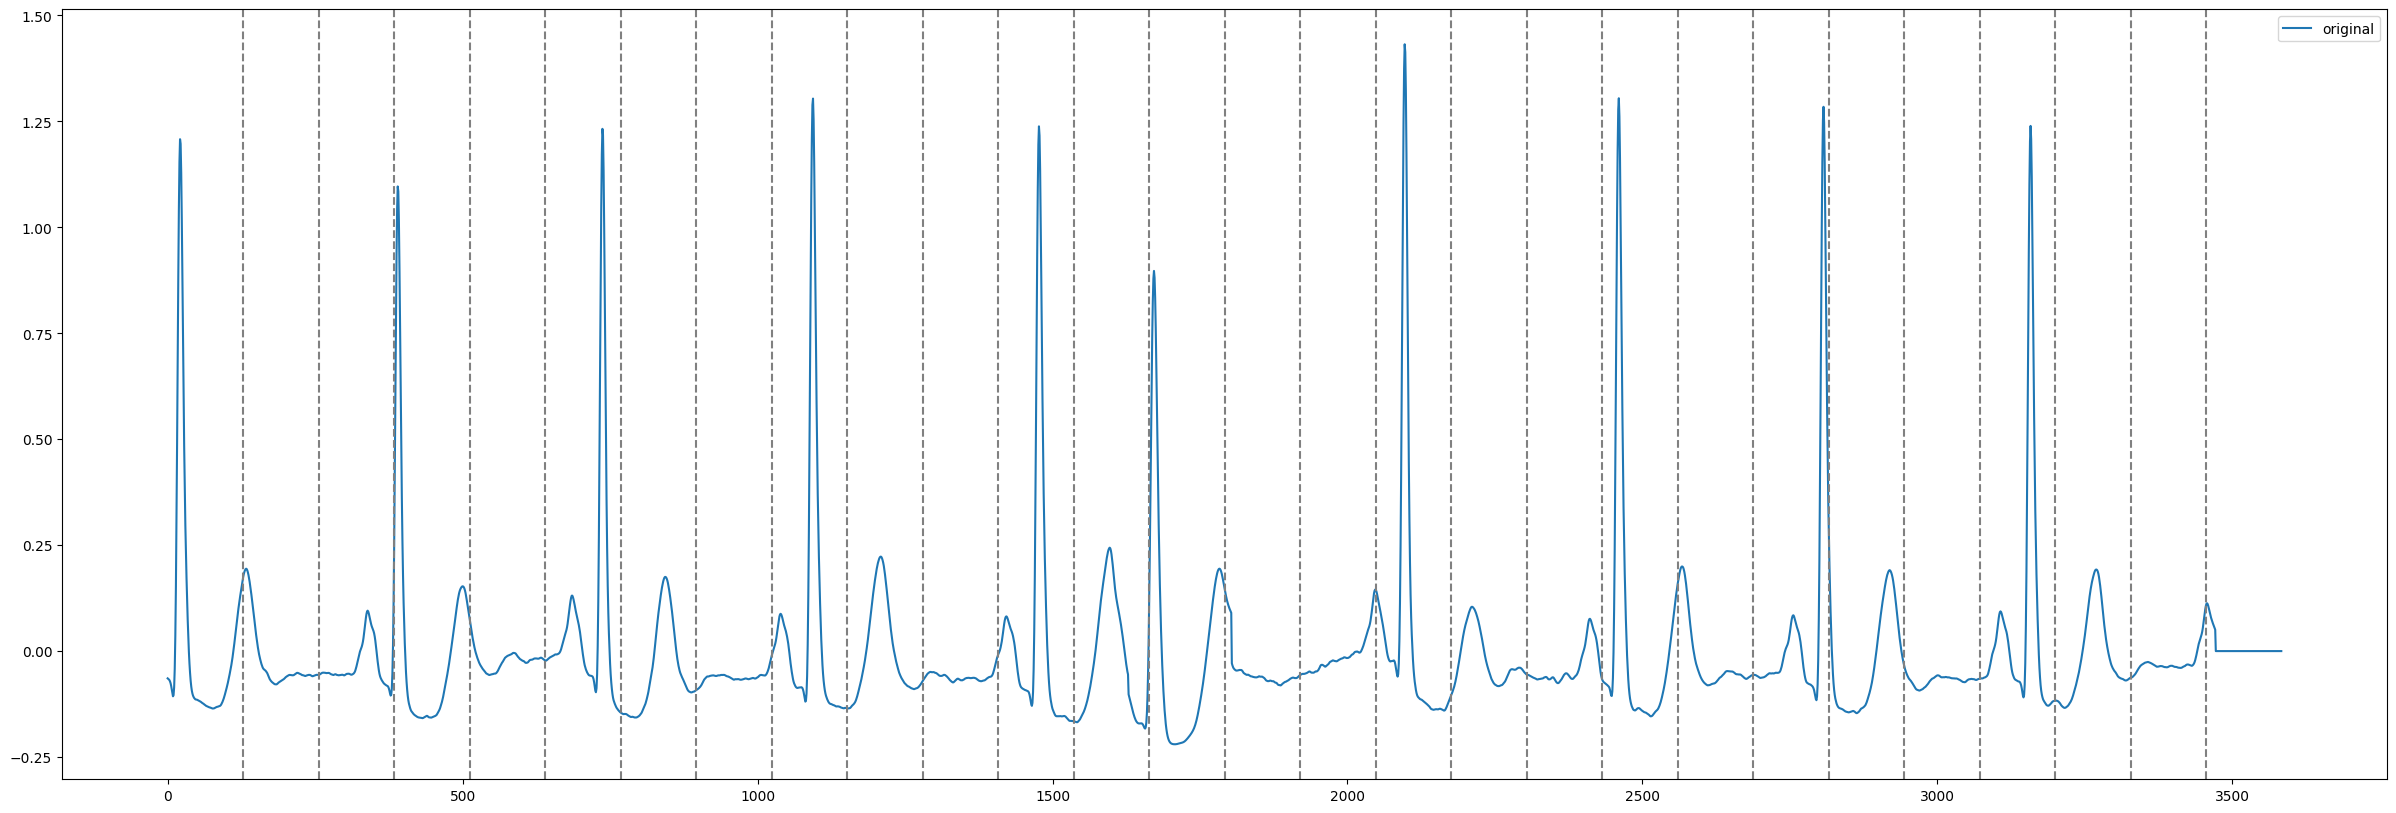

In [7]:
# get one sample from the dataset
import numpy as np
from torch.utils.data import DataLoader
from torch.nn import functional as F

from dataset.mit_bih import ECGMITBIHDataset
dataset = ECGMITBIHDataset('/media/Volume/data/MIT-BHI/data/', subset='train', num_leads=1, oversample=False, random_shift=False, patch_size=patch_size, normalize=False, nkclean=True)
# first index of non zero label
# vars = []
        

xlstm = xlstm.to('cuda')
xlstm.eval()
# idx with S: 420
# idx with v: 1967
# idx with F: 4362
# idx with Q: 360
# idx with N: 7544
# get test dataset
sample = dataset[420]
print(sample['label'])
tab_data = sample['tab_data']
sample = sample['signal'].to('cuda').unsqueeze(0)
print('sample shape', sample.shape)

sample = F.pad(sample, (0, 0, 0, patch_size - sample.shape[1] % patch_size))

reconstruct, _, _, _ = xlstm.reconstruct(sample, tab_data) # [batch_size, seq_len // 64, patch_size]
#shift_x = sample[:, :reconstruct.shape[1]]
shift_x = sample[:, patch_size:].squeeze()


shift_reconstruct = reconstruct[:, :-patch_size]

# try to reconstruct one element at a time
reconstruct = reconstruct.view(1, -1)
shift_x = shift_x.view(1, -1)
print('rec shape', reconstruct.shape)
print('shift_x shape', shift_x.shape)


# plot the original and reconstructed signal
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 10))
plt.plot(shift_x.squeeze().cpu().numpy(), label='original')
# plt.plot(shift_reconstruct.squeeze().detach().cpu().numpy(), label='reconstructed')
# add a pipe avery 64 samples
for i in range(1, sample.shape[1] // patch_size - 1):
    plt.axvline(x=patch_size*i, color='gray', linestyle='--')
plt.legend()



sample shape torch.Size([1, 3712, 1])
prediction_tokens shape torch.Size([1, 2560])
predictions shape torch.Size([2560])


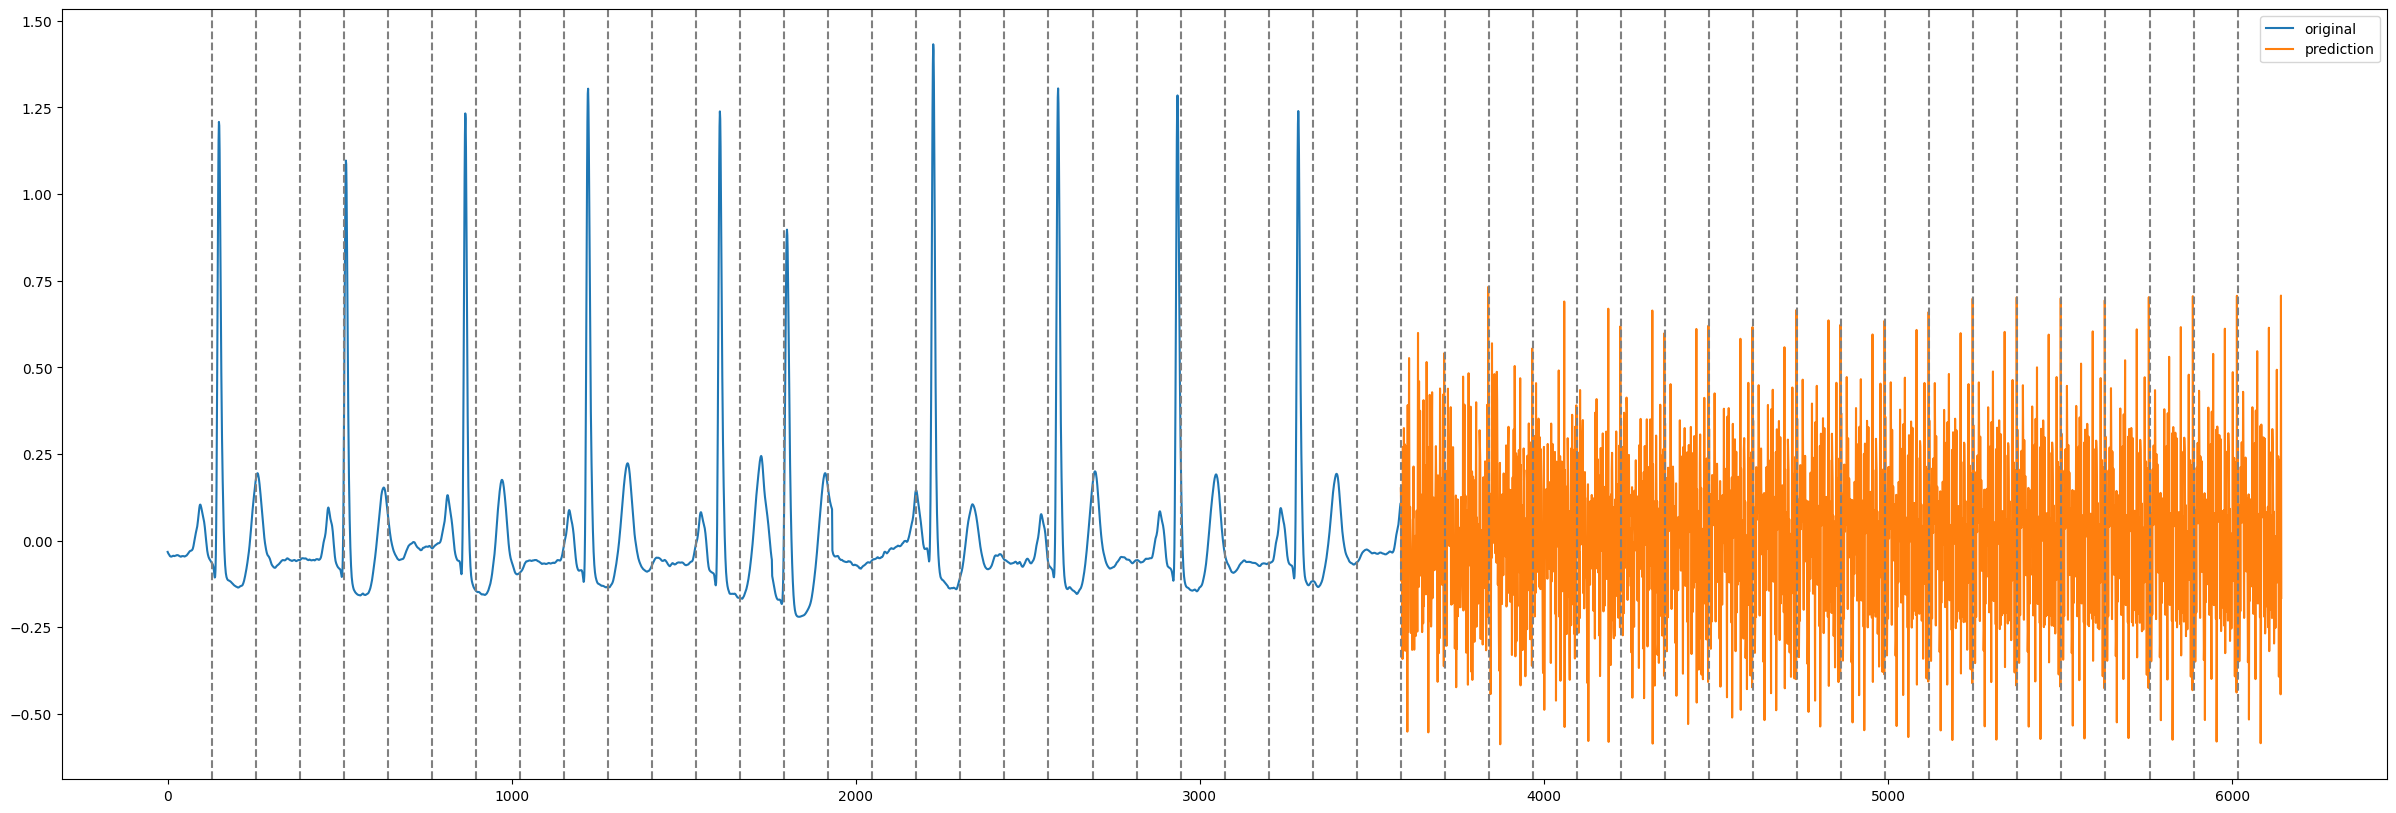

In [8]:
# given the sample predict a new signal

# get the prediction
#sample = sample[:, :600]
print('sample shape', sample.shape)
prediction_tokens = torch.zeros([1, 0]).to('cuda')
for i in range(0, 20):
    if i == 0:
        new_sample = sample
    else:
        flatten_preds = prediction_tokens.view(1, -1)
        # print('flatten_preds shape', flatten_preds.shape)
        # print('sample shape', sample.shape)
        new_sample = torch.cat([sample, flatten_preds.unsqueeze(-1)], dim=1)
        # print('new_sample shape', new_sample.shape)
    # print('new_sample shape', new_sample.shape)
    r1, r2, r3, r4 = xlstm.reconstruct(new_sample, tab_data=tab_data)
    # print('reconstruct shape', reconstruct.shape)
    # the last token is the prediction
    p1 = r1[:, -patch_size:]
    p2 = r2[:, -patch_size:]
    p3 = r3[:, -patch_size:]
    p4 = r4[:, -patch_size:]
    # print('prediction shape', prediction.shape)
    # print('prediction_tokens shape', prediction_tokens.shape)
    # print('prediction shape', prediction.shape)
    # print('prediction_tokens shape', prediction_tokens.shape)
    prediction_tokens = torch.cat([prediction_tokens, p1], dim=1) #, p2, p3, p4], dim=1)

print('prediction_tokens shape', prediction_tokens.shape)
predictions = prediction_tokens.squeeze().view(-1)
print('predictions shape', predictions.shape)

# plot the signal
plt.figure(figsize=(30, 10))
plt.plot(sample[0, :-patch_size].squeeze().cpu().numpy(), label='original')
plt.plot(range(len(sample[0, :-patch_size]), len(sample[0, :-patch_size]) + len(predictions)), predictions.detach().cpu().numpy(), label='prediction')
# add a pipe avery 64 samples
for i in range(1, (len(sample[0]) + len(predictions)) // patch_size -1):
   plt.axvline(x=patch_size*i, color='gray', linestyle='--')
plt.legend()

In [4]:
import dataset.code_15 as code_15
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt    
from tqdm import tqdm

train_dataset = code_15.ECGCODE15Dataset('/media/Volume/data/CODE15/unlabeled_records_360', num_leads=12, random_shift=True, patch_size=64, normalize=False)
train_dataset_cleaned = code_15.ECGCODE15Dataset('/media/Volume/data/CODE15/unlabeled_records_360_nkclean', num_leads=12, random_shift=True, patch_size=64, normalize=False)

vars = []
for i in tqdm(range(len(train_dataset))):
    vars.append((i, train_dataset[i]['signal'].var().item()))
    


loaded 343287 records
loaded 343287 records


100%|██████████| 343287/343287 [01:54<00:00, 3003.30it/s]


low 1
high 605
middle 342681


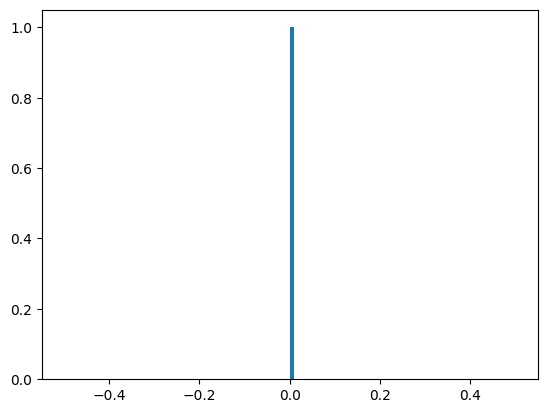

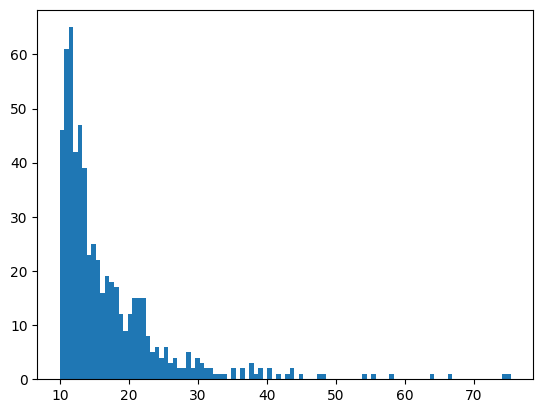

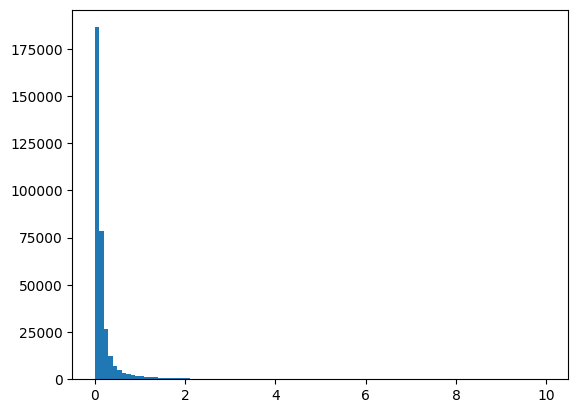

In [5]:
variances = [v[1] for v in vars]
low_variances = [v for v in variances if v < 0.0001]
print('low', len(low_variances))
hihg_variances = [v for v in variances if v > 10 ]
len(hihg_variances)
print('high', len(hihg_variances))
middle_variances = [v for v in variances if v > 0.0001 and v < 10]
len(middle_variances)
print('middle', len(middle_variances))

# plot the histogram of the signal length
plt.hist(low_variances, bins=100)
plt.show()
plt.hist(hihg_variances, bins=100)
plt.show()
plt.hist(middle_variances, bins=100)
plt.show()

number of samples 8
number of samples with high variance 0


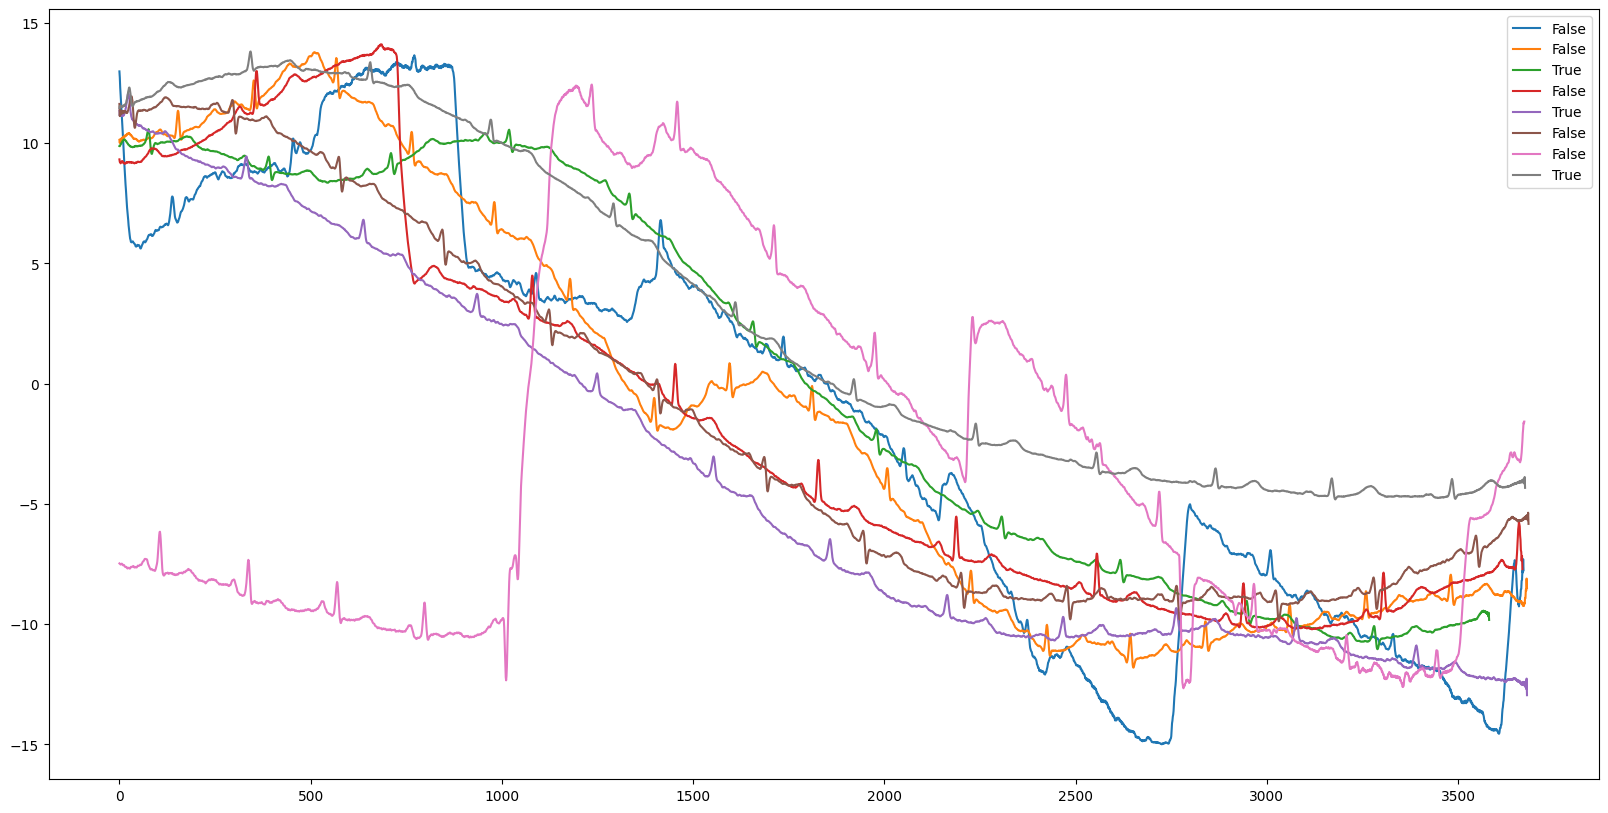

In [10]:
# get the index of the signal with highest variance
max_idx = sorted(vars, key=lambda x: x[1])
# plot the signal with the highest variance

# plot the first 10 samples
count = 0
plt.figure(figsize=(20, 10))
for i in range(1, len(max_idx)):
    sample = train_dataset[max_idx[-i][0]]['signal']
    # sample = (sample - sample.mean()) / sample.std()

    max_val = sample.max().item()
    min_val = sample.min().item()
    tab_data = train_dataset[max_idx[-i][0]]['tab_data']
    # if (max_val > 15 or min_val < -15):
    #print('tab_data', tab_data)
    plt.plot(train_dataset[max_idx[-i][0]]['signal'].squeeze().cpu().numpy(), label=f'{tab_data.loc["normal_ecg"].values[0]}')
    if max_idx[-i][1] < 50:
        break

print('number of samples', i)
print('number of samples with high variance', count)
plt.legend()
plt.show()

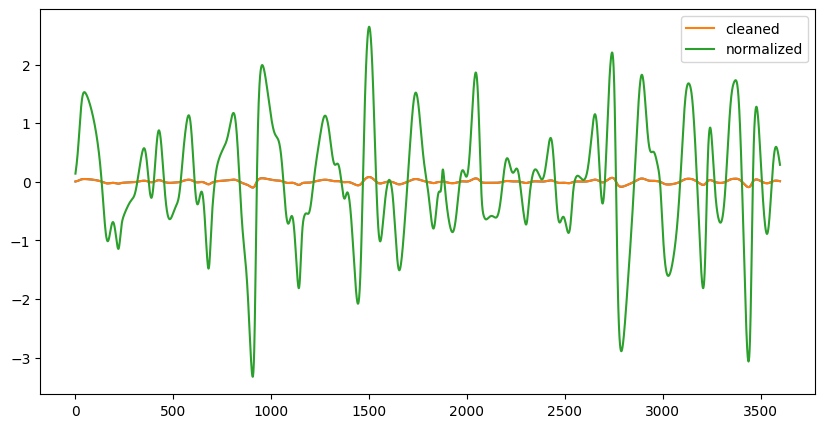

In [ ]:
from torch import nn    

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean
    

sd = series_decomp(25)


# plot the signal with the highest variance
sample = train_dataset[100]['signal']

plt.figure(figsize=(10, 5))
plt.plot(sample['signal'].squeeze().cpu().numpy())
plt.show()


In [ ]:
batch = next(iter(train_dataloader))

# plot the first sample
x = batch["signal"].to('cuda')
mask = batch["mask"].to('cuda')
tab_data = batch["tab_data"]
# print('initial mask shape', mask.shape)
# print('initial x shape', x.shape)
reconstruct, _, _, _ = xlstm.reconstruct(x, tab_data) 

# get rid of the exeding part on the original signal
shift_x = x[:, :reconstruct.shape[1]]
shift_x = shift_x[:, patch_size:].squeeze()

mask_shifted = mask[:, :reconstruct.shape[1]]
mask_shifted = mask_shifted[:, patch_size:].squeeze()

mask_idxs, lol = torch.where(mask_shifted == 0)
print('lol', lol.shape)

shift_reconstruct = reconstruct[:, :-patch_size]

#print('mask shape', mask.shape)
#print('x shape', x.shape)   
#print('reconstruct shape', shift_reconstruct.shape)

# shift_reconstruct = shift_reconstruct.masked_fill(mask_shifted, 0)
# shift_x = shift_x.masked_fill(mask_shifted, 0)

print('mask_shifted shape', mask_shifted.shape)
print('shift_x shape', shift_x.shape)
print('max_idxs has shape', mask_idxs.shape)
print('max_idxs 0 is ', mask_idxs[0])
print('shift_reconstruct shape', shift_reconstruct.shape)
# add a pipe avery 64 samples

# m = shift_x == mask_idxs
# plot the first sample
plt.figure(figsize=(10, 5))
plt.plot(shift_x[0].squeeze().cpu().numpy(), label='original')
plt.plot(shift_reconstruct[0].squeeze().detach().cpu().numpy(), label='reconstructed')
ma_inp = shift_x[0] * mask_shifted[0]
print('ma_inp shape', ma_inp.shape)
plt.plot(ma_inp.cpu().numpy(), label='lol')
#plot mask
# plt.plot(mask_shifted[0].cpu().numpy(), label='mask')
plt.legend()

In [ ]:
from matplotlib import pyplot as plt    

train_dataset = code_15.ECGCODE15Dataset('/media/Volume/data/CODE15/unlabeled_records_360', num_leads=12, random_shift=False, patch_size=64, normalize=False)
train_original = code_15.ECGCODE15Dataset('/media/Volume/data/CODE15/unlabeled_records', num_leads=12, random_shift=False, patch_size=64, normalize=False)

# plot the first sample


loaded 345073 records
loaded 345109 records


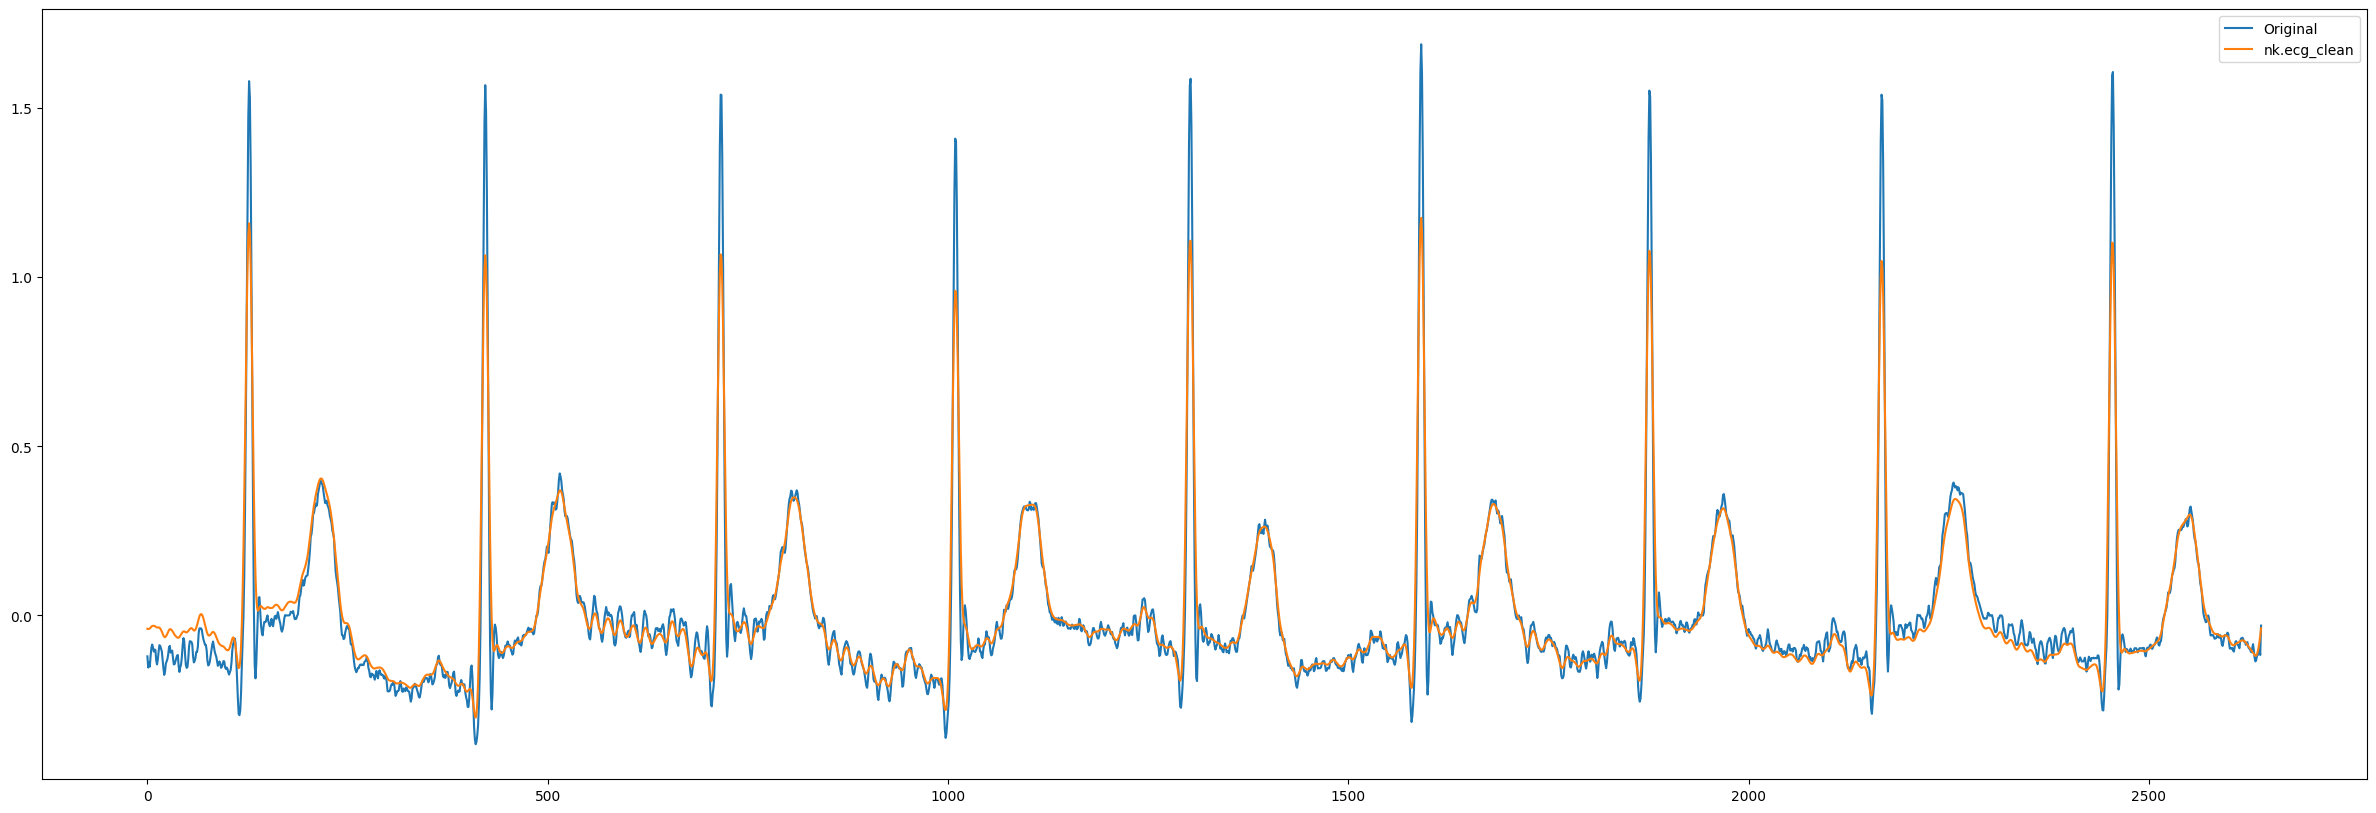

In [ ]:
# compare different types of cleaning
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt

# get the first sample
sample = train_dataset[3]
sample = sample['signal']
# apply nk.ecg_clean
cleaned_sample = nk.ecg_clean(sample[:], sampling_rate=360, method='nk')
# apply nk.ecg_clean
vg_cleaned_sample = nk.ecg_clean(sample[:], sampling_rate=360, method='vg')

engzeemod2012_cleaned_sample = nk.ecg_clean(sample[:], sampling_rate=360, method='engzeemod2012') 

filter = BandPassFilter(low_cutoff=0.5, high_cutoff=60, sampling_rate=360)
sample_bp = filter(sample.unsqueeze(0))



plt.figure(figsize=(30, 10))
plt.plot(sample[:].squeeze(), label='Original')
plt.plot(cleaned_sample.squeeze(), label='nk.ecg_clean')
# plt.plot(sample_bp.squeeze(), label='sample_bp')
# lt.plot(vg_cleaned_sample.squeeze(), label='vg.ecg_clean')
# plt.plot(engzeemod2012_cleaned_sample.squeeze(), label='engzeemod2012.ecg_clean')
# plt.plot(cleaned_sample.squeeze(), label='Band pass filter')
plt.legend()


torch.Size([4096])


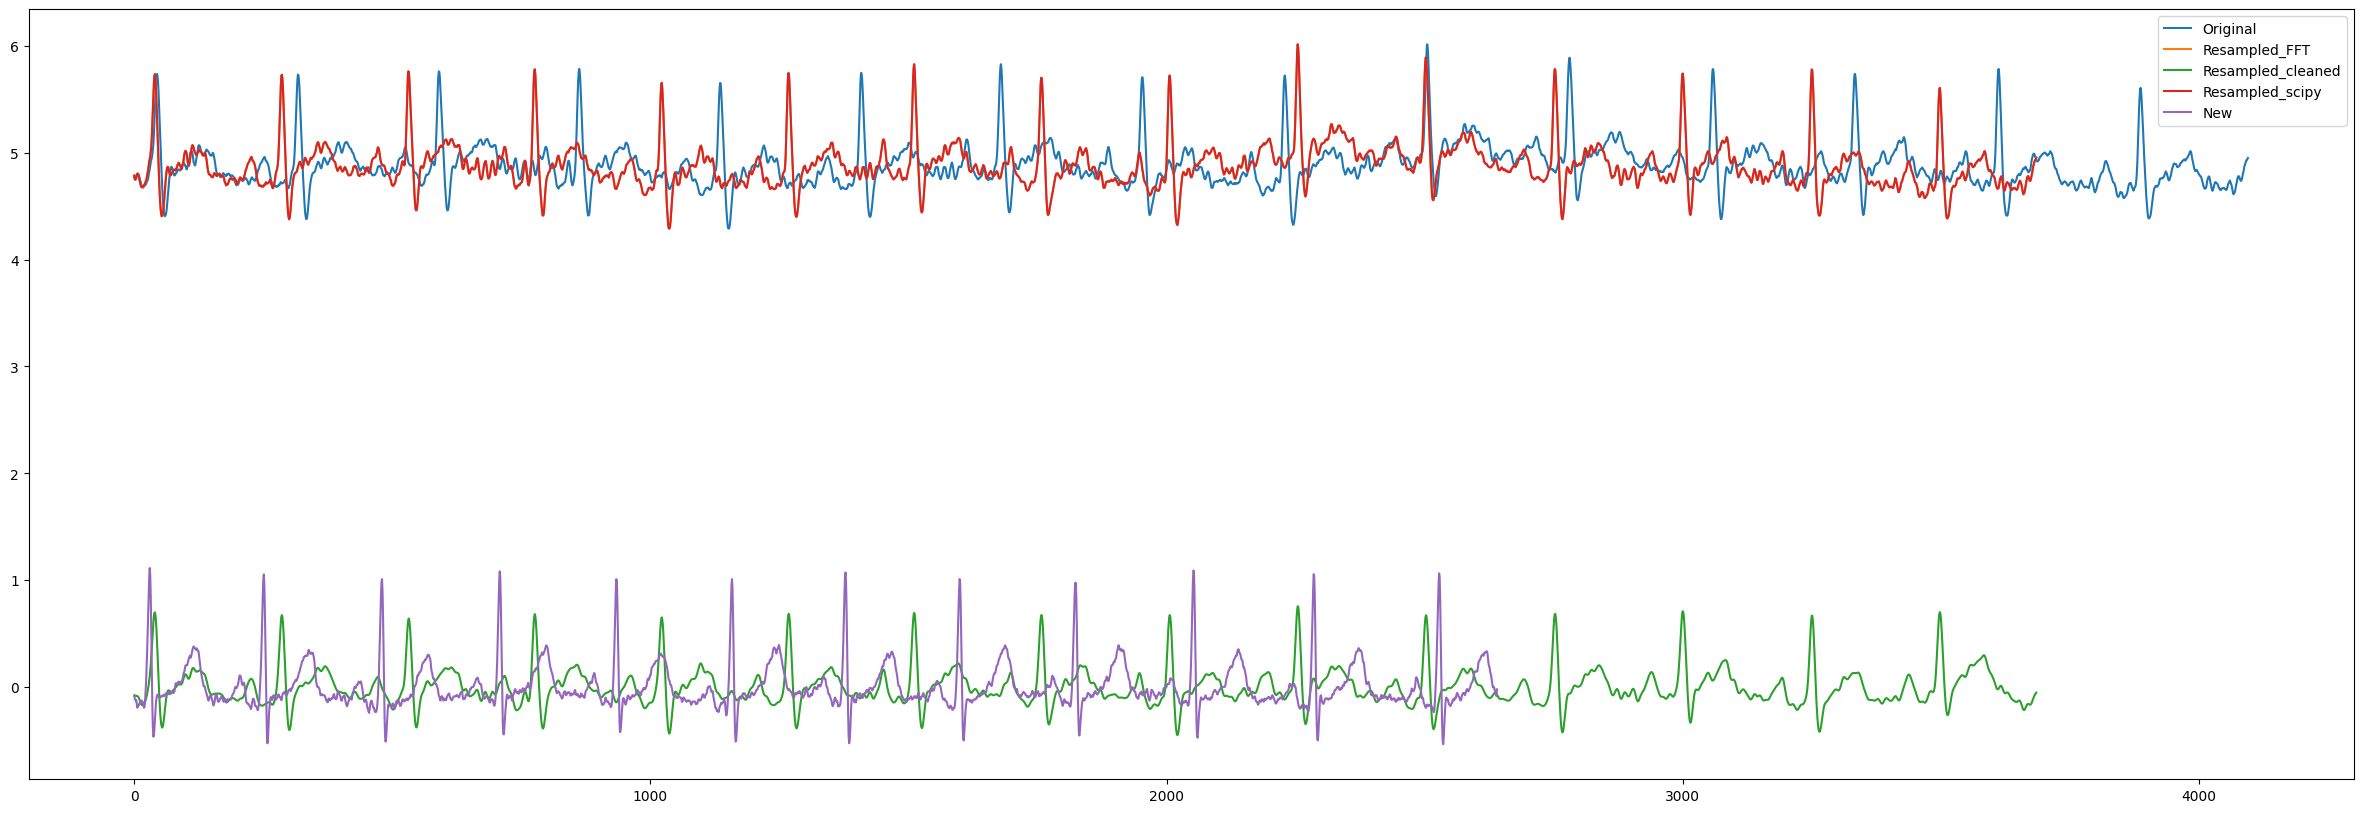

In [ ]:
idx = 9878
sample_orig = train_original[idx]['signal'][:, 1]
sample_new = train_dataset[idx]['signal']
print(sample_orig.shape)
plt.figure(figsize=(30, 10))
plt.plot(sample_orig, label='Original')


resampled = nk.signal_resample(sample_orig, sampling_rate=400, desired_sampling_rate=360, method='FFT')
plt.plot(resampled, label='Resampled_FFT')
resampled = nk.signal_resample(sample_orig, sampling_rate=400, desired_sampling_rate=360, method='FFT')
resampled = nk.ecg_clean(resampled, sampling_rate=360, method='nk')
plt.plot(resampled, label='Resampled_cleaned')
#scipy resample
from scipy.signal import resample
resampled = resample(sample_orig, len(sample_orig) * 360 // 400)
plt.plot(resampled, label='Resampled_scipy')

plt.plot(sample_new, label='New')   

plt.legend()


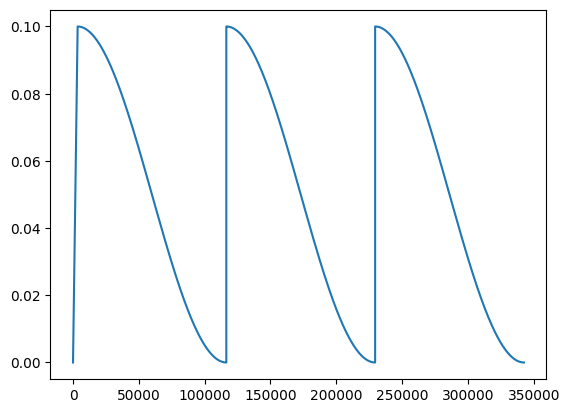

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup


model = torch.nn.Linear(10, 1)    
optimizer = optim.SGD(model.parameters(), lr=0.1)
warmup_steps = 3425
epochs = 100
train_steps = 3425 * epochs

lr_scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=train_steps, num_cycles=(train_steps // warmup_steps) // 30)

lrs = []
for epoch in range(train_steps):
    # train step goes here
    lr_scheduler.step(epoch)
    lrs.append(optimizer.param_groups[0]['lr'])

plt.plot(lrs)
plt.show()